# [야외 공공체육시설 리모델링 최적 입지 선정](https://bigdata.seoul.go.kr/main.do)
처음으로 도전한 빅데이터 공모전입니다. 20등이내에 들었지만 아쉽게도 수상에는 떨어졌습니다.  
분석과 검증 측면에서 부족했던 부분을 feedback으로 남기고 앞으로 이런 실수는 반복하지 않도록 발전하는 계기로!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DongChanKIM2/seoul-bigdata-competition/blob/main/Gym_position_predict.ipynb)

## 필요한 라이브러리 불러오기

In [ ]:
import pandas as pd # 데이터 처리
from pandas import DataFrame # 데이터를 표 형식으로 변환
!pip install lightgbm
from sklearn.metrics import roc_auc_score, roc_curve # 정확성과 별개로 auc 평가
from sklearn.metrics import mean_squared_error, r2_score # 정확성 평가 지표
from sklearn.model_selection import train_test_split # train, test split
import lightgbm as lgb
import lightgbm
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

%matplotlib inline #구버전의 주피터 노트북에서 그래프 설정
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

UsageError: unrecognized arguments: #구버전의 주피터 노트북에서 그래프 설정


## 데이터 불러오기

+ 국민체육진흥공단 :https://www.kspo.or.kr/kspo/main/main.do
+ 서울 열린데이터 광장 :https://data.seoul.go.kr/
+ 서울시 주민등록 인구 :https://bigdata.seoul.go.kr/main.do
+ 코시스 :https://kosis.kr/index/index.do

In [ ]:
data=pd.read_csv('RAW_DATA.csv')
data.head()

,FACI_GB_NM,FCOB_NM,FTYPE_NM,FACI_STAT,Y,FACI_ROAD_ADDR1,FACI_POINT_X,FACI_POINT_Y,CP_NM,CPB_NM,INOUT_GBN,NATION_YN,ATNM_CHK_YN
0,공공,간이운동장,간이운동장,정상운영,1,전라남도 장성군 삼계면 영장로 1585,126.661125,35.257708,전라남도,장성군,결측치,N,N
1,신고,당구장업,당구장,정상운영,1,광양시 중마로 230 (중동,127.689695,34.945516,전라남도,광양시,없음,N,Y
2,신고,당구장업,당구장,정상운영,1,광양시 광양읍 서북2길 6 ((2층)),127.578813,34.971214,전라남도,광양시,없음,N,Y
3,공공,수영장,수영장,정상운영,1,경상남도 고성군 고성읍 송학고분로 193,128.310723,34.979313,경상남도,고성군,실내,N,N
4,공공,씨름장,씨름장,정상운영,1,경상남도 고성군 고성읍 송학고분로 193,128.310723,34.979313,경상남도,고성군,실내,N,N


데이터 info 및 결측치 확인

In [ ]:
data.dtypes

FACI_GB_NM          object
FCOB_NM             object
FTYPE_NM            object
FACI_STAT           object
Y                    int64
FACI_ROAD_ADDR1     object
FACI_POINT_X       float64
FACI_POINT_Y       float64
CP_NM               object
CPB_NM              object
INOUT_GBN           object
NATION_YN           object
ATNM_CHK_YN         object
dtype: object

In [ ]:
data.isnull().sum()

FACI_GB_NM         0
FCOB_NM            0
FTYPE_NM           0
FACI_STAT          0
Y                  0
FACI_ROAD_ADDR1    0
FACI_POINT_X       0
FACI_POINT_Y       0
CP_NM              0
CPB_NM             0
INOUT_GBN          0
NATION_YN          0
ATNM_CHK_YN        0
dtype: int64

분석을 위한 데이터 타입 변환

In [ ]:
data.FACI_GB_NM=data.FACI_GB_NM.astype("category")
data.FCOB_NM=data.FCOB_NM.astype("category")
data.FTYPE_NM=data.FTYPE_NM.astype("category")
data.CP_NM=data.CP_NM.astype("category")
data.CPB_NM=data.CPB_NM.astype("category")
data.INOUT_GBN=data.INOUT_GBN.astype("category")
data.NATION_YN=data.NATION_YN.astype("category")
data.ATNM_CHK_YN=data.ATNM_CHK_YN.astype("category")
data.Y=data.Y.astype("category")

data=data.drop('FACI_STAT',axis=1) #Y와 같은 변수

In [ ]:
y=data.Y
x=data.drop('Y',axis=1)
x=x.drop('FACI_ROAD_ADDR1',axis=1) #모든 행이 다른 값을 가지는 고유 변수 -> 과적합이 일어나기 때문에 제거

### LightGBM 파라미터 값 설정

In [ ]:
param = {'boosting_type': 'gbdt','num_leaves':10, 'objective':'binary','max_depth':10,'learning_rate':.05} 
#max_depth, learning rate높이면 과적화,but 변수가 너무 많으면 max_depth 증가(20~30)
param['metric'] = ['auc', 'binary'] #auc가 auccray가 아니라 auc 면적, 지금은 y값이 0,1이라 binary이지만 y값이 2이상이면 다항분포 사용
num_boost_round = 100
early_stopping_rounds = 30 #30번부터 차이가 없으면 30번 이후에서 끝내기
evals_result = {}
num_round = num_boost_round

### AUC

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3)
train_data=lgb.Dataset(x_train,label=y_train)
lgbm=lgb.train(param,train_data,num_round)
ypred=lgbm.predict(x_test)

#data1 lightGBM AUC
print("data AUC")
print(roc_auc_score(y_test,ypred))

data AUC
0.8372593487557939


### F1 Score

In [ ]:
ypred_result=ypred 
#F1 Score맞추기 위해서 하는 것, 모델 2개를 비교할땐 auc,
#여기의 auc는 다 영역임, but 0이 9개 ,1이 1개이면 전부 0이어도 정확성이 높게 나오므로 f1 score이 유의함 0,1 비율 5:5면 acuracy=f1score
for i in range(0,1):
    for j in range(0,len(ypred)):
        #0,1 맞추을 마주는 비율이 거의 같아지는 cut off 값을  찾아서 적용합니다.
        if ypred[j]>0.85:
            ypred_result[j]=1
        else:
            ypred_result[j]=0

pred_prob=pd.DataFrame(ypred)
pred_result=pd.DataFrame(ypred_result)

print("Crosstab")
print(pd.crosstab(ypred_result,y_test))


Crosstab
Y         0      1
row_0             
0.0    2555   5196
1.0     944  17696


In [ ]:
arr=pd.crosstab(y_test,ypred_result).to_numpy()
TN=arr[0][0]
TP=arr[1][1]
FN=arr[1][0]
FP=arr[0][1]
recall=TP/(TP+FN)
precision=TP/(TP+FP)
zero=TN/(TN+FP)
f1score=(precision*recall*2)/(precision+recall)

print("0,1 맞추는 비율 (1에 가까워야 0,1 모두 잘 맞추는 결과)")
print(recall/zero)
print("recall")     
print(recall)
print("precision")     
print(precision)

print("f1score")
print(f1score)

0,1 맞추는 비율 (1에 가까워야 0,1 모두 잘 맞추는 결과)
1.0586305199639043
recall
0.7730211427572952
precision
0.9493562231759657
f1score
0.8521621881922373


### 중요 변수 5개 추출

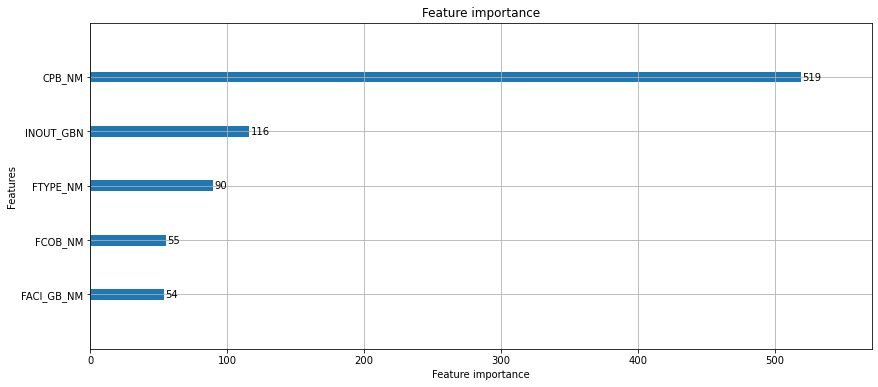

In [ ]:
plt.rcParams["figure.figsize"] = (14,6)
plt.rc('font',size=10)
ax = lgb.plot_importance(lgbm, max_num_features=5)
plt.show()

### Predict Score 엑셀 파일에 병합해 추출

In [ ]:
ypred=lgbm.predict(data.drop('Y',axis=1).drop('FACI_ROAD_ADDR1',axis=1))
ypred_prob= pd.DataFrame([ypred]).transpose()
result=pd.merge(data,ypred_prob,how="outer",left_index=True, right_index=True)

In [ ]:
result.head() #predict값 붙이기

,FACI_GB_NM,FCOB_NM,FTYPE_NM,Y,FACI_ROAD_ADDR1,FACI_POINT_X,FACI_POINT_Y,CP_NM,CPB_NM,INOUT_GBN,NATION_YN,ATNM_CHK_YN,0
0,공공,간이운동장,간이운동장,1,전라남도 장성군 삼계면 영장로 1585,126.661125,35.257708,전라남도,장성군,결측치,N,N,0.993107
1,신고,당구장업,당구장,1,광양시 중마로 230 (중동,127.689695,34.945516,전라남도,광양시,없음,N,Y,0.787857
2,신고,당구장업,당구장,1,광양시 광양읍 서북2길 6 ((2층)),127.578813,34.971214,전라남도,광양시,없음,N,Y,0.787857
3,공공,수영장,수영장,1,경상남도 고성군 고성읍 송학고분로 193,128.310723,34.979313,경상남도,고성군,실내,N,N,0.994380
4,공공,씨름장,씨름장,1,경상남도 고성군 고성읍 송학고분로 193,128.310723,34.979313,경상남도,고성군,실내,N,N,0.987444


In [ ]:
result.to_csv("result.csv")